# 스팀 리뷰데이터 EDA

## 절차

1. 긍/부정 워드클라우드
    - 감성 레이블 비율 확인
    - text와 label 컬럼만 추출 후 중립 라벨 제외하여 긍/부정 리뷰만 분석
    - 긍/부정 리뷰 분리하여 키워드 추출 후 한국어로 번역
    - 워드클라우드

2. 플레이타임으로 나누는 만족도 비교
    - play_time을 기준으로 분석 집단을 나누기 위해 별도 데이터프레임 생성
    - 분석 집단을 저플타, 고플타 로 나누어 구분
    - 그룹별 긍/부정 비율 계산

3. 추천 여부와 label의 상관관계
    - label=1 & prefer=1 (긍정+추천)
    <br>label=0 & prefer=0 (부정+비추천)
    <br>label=1 & prefer=0 (긍정+비추천)
    <br>label=0 & prefer=1 (부정+추천)
    <br>로 나누기
    - 각 케이스별 비율 산출 후 히트맵
    - 불일치 그룹 행동 지표 비교

- label
    - 0 : 부정
    - 1 : 긍정
    - 2 : 중립

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('최종_유저데이터6차.csv')

In [3]:
steam_df = df[['text', 'label', 'play_time', 'prefer', '작성일', 'recently_game1', 'recently_game2', 'recently_game3']]

In [4]:
steam_df

,text,label,play_time,prefer,작성일,recently_game1,recently_game2,recently_game3
0,really bad,0,4.6,0,2025-08-04,Overwatch® 2,Apex Legends,Dead by Daylight
1,wen game,2,34.2,1,2025-08-04,R.E.P.O.,Overwatch® 2,VRChat
2,ww,2,14.3,1,2025-08-04,비공개,비공개,비공개
3,"Really annoying sometimes, really fun sometimes",1,0.2,1,2025-08-04,비공개,비공개,비공개
4,I love this balanced game and matchmaking is a...,1,667.5,0,2025-08-04,Counter-Strike 2,Overwatch® 2,Don't Starve
...,...,...,...,...,...,...,...,...
8331,haha no,1,151.6,0,2025-04-27,비공개,비공개,비공개
8332,"It's good, i prefer this over owerwatch 1, ikn...",1,1.1,1,2025-04-27,비공개,비공개,비공개
8333,I'm funny ...,1,210.4,1,2025-04-27,비공개,비공개,비공개
8334,"Trash, don't even bother with it",1,4.8,0,2025-04-27,비공개,비공개,비공개


## 1. 긍/부정 워드클라우드

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter
from deep_translator import MyMemoryTranslator
from matplotlib import font_manager

In [12]:
# 라벨별 비율 확인하기
label_counts = steam_df['label'].value_counts().sort_index()

# 라벨 이름 매핑
label_names = {0: '부정', 1: '긍정', 2: '중립'}
labels = [label_names[i] for i in label_counts.index]

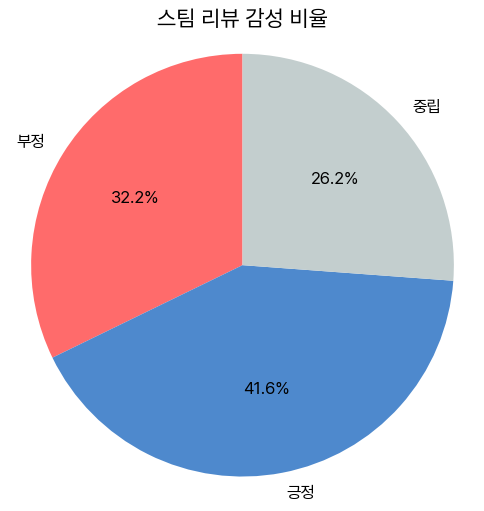

In [20]:
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 색상 매핑
colors = ['#FF6B6B', "#4E89CD", "#C3CECE"]  # 부정=빨강, 긍정=청록, 중립=회색

# 파이차트
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("스팀 리뷰 감성 비율", fontsize=16)
plt.axis('equal')  # 원형 유지
plt.show()

- 전체적으로 고르게 분포되어 있음을 알 수 있다.

In [21]:
# 리뷰 텍스트와 라벨만 따로 빼기
pn_word = steam_df[['text', 'label']]

In [22]:
# 중립 제외하기
pn_word = pn_word[pn_word['label'].isin([0, 1])].copy()

In [23]:
def clean_text(text):
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [27]:
# 긍/부정 텍스트 합치기
pos_texts = pn_word[pn_word['label'] == 1]['text'].apply(clean_text)
neg_texts = pn_word[pn_word['label'] == 0]['text'].apply(clean_text)
print(len(pos_texts), len(neg_texts))

3469 2685


### 긍정

In [41]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    # Series일 경우 리스트로 변환
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    if len(texts) == 0:
        return []

    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 영어 불용어 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

# 사용 예시
pos_kw = top_keywords(pos_texts, topk=300, ngram=(1,2))
neg_kw = top_keywords(neg_texts, topk=300, ngram=(1,2))

print("POS top 5:", pos_kw[:5])
print("NEG top 5:", neg_kw[:5])

POS top 5: [('game', 0.048724370013997625), ('good', 0.03985233009587693), ('fun', 0.03432772967677763), ('play', 0.02549577022440122), ('like', 0.01901954223887124)]
NEG top 5: [('game', 0.04747638595254724), ('play', 0.023413093889484884), ('bad', 0.02265674882366059), ('shit', 0.020367785514828426), ('hate', 0.016115271897627705)]


In [42]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

pos_kw_ko = translate_list(pos_kw)
neg_kw_ko = translate_list(neg_kw)

# 미리보기
for w, ko, sc in pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")


[POS] game -> 게임을 (0.0487)
[POS] good -> 선 (0.0399)
[POS] fun -> 재밌는 (0.0343)
[POS] play -> 플레이 (0.0255)
[POS] like -> 좋아요 (0.0190)
[POS] better -> 더 좋은 (0.0177)
[POS] love -> 사랑은 오래 참는다 (0.0151)
[POS] good game -> 멋져요 (0.0151)
[POS] overwatch -> 감시자 (0.0124)
[POS] best -> 제일 (0.0112)
[NEG] game -> 게임을 (0.0475)
[NEG] play -> 플레이 (0.0234)
[NEG] bad -> 나쁨 (0.0227)
[NEG] shit -> 염병 (0.0204)
[NEG] hate -> 증오 (0.0161)
[NEG] just -> 오직 (0.0126)
[NEG] ass -> 나귀 (0.0117)
[NEG] don -> 돈 (0.0102)
[NEG] blizzard -> 눈보라 (0.0102)
[NEG] good -> 선 (0.0093)


In [43]:
pos_df_kw = pd.DataFrame(pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("23-1.리뷰_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("23-1.리뷰_부정단어.csv", index=False, encoding="utf-8-sig")

print("✅ 저장 완료: 23-1.리뷰_긍정단어.csv / 23-1.리뷰_부정단어.csv")

✅ 저장 완료: 23-1.리뷰_긍정단어.csv / 23-1.리뷰_부정단어.csv


In [44]:
pos_df_kw = pd.read_csv("23-1.리뷰_긍정단어.csv", encoding="utf-8-sig")

In [76]:
pos_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,playing,플레이하다,0.009188
1,marvel rivals,마블 라이벌즈,0.008978
2,stadium,스타디움,0.008314
3,time,시간,0.008078
4,want,원하다,0.007750
5,friends,친구,0.007661
6,played,실행,0.006881
7,recommend,권장하다,0.006643
8,new,새로운,0.005421
9,people,사람들,0.005357


In [49]:
pos_df_kw = pos_df_kw.drop([0, 1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11,12, 14, 16, 19, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 36, 37, 40, 41, 42, 43, 45,47, 51,52,53,54,57,59,60,62,63,64,65,66,67,69,70,71,72,73,74,76,77,78,79,80,81,82,84,85,89,90,92,94,95,97,99,101,102,103,106,
107,108, 109, 110, 111, 113, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131,134, 135, 137, 138, 139, 140, 142, 143, 144, 145, 147, 148, 149,
152, 153, 154, 157, 158, 159, 161, 163, 164, 165, 166, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 194, 195, 197, 198, 199]).reset_index(drop=True)

In [ ]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "재생 중": "플레이하다",
    "싶다": "원하다",
    "놀라운 라이벌": "마블 라이벌즈",
    "재생":"실행",
    "새": "새로운",
    "백성":"사람들",
    "눈보라": "블리자드",
    "문자": "캐릭터",
    "gcc (가급적 gcc를 추천하지만 다른 C 컴파일러도 동작하기는 한다.)": "만들다",
    "유독": "중독적인",
    "community": "커뮤니티",
    "허락하다": "같이",
    "경기장 모드": "스타디움 모드",
    "인물": "캐릭터",
    "경기": "매치",
    "선수": "플레이어",
    "피부": "스킨",
    "중 다음과 일치 :": "매치"
})

In [55]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_3056\2395018422.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


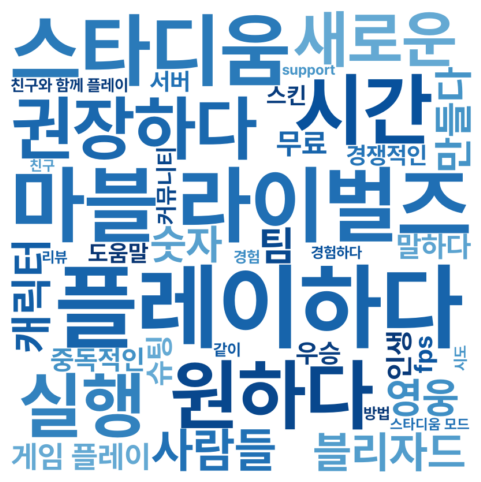

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:40], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


### 긍정 분석

1. 마블 라이벌스, 스타디움, 경기, fps
    - 경쟁작 '마블 라이벌스'나 스타디움모드가 긍정적으로 언급된다
    - PvP 환경, 대규모 경기 시스템이 긍정 인상을 주고 있을 가능성 높음

2. 영웅, 스킨
    - 캐릭터 스킨 출시, 영웅 밸런스 패치 등 꾸준한 업데이트가 긍정적으로 작용했을 가능성이 있다

3. 실행하다, 플레이하다, 서버, 시간, 숫자, 리뷰
    - 접근성과 플레이 경험 자체에 대한 긍정 반응
    - 로딩 속도, 진입 장벽 완화 등 UX 개선을 지속하면 긍정 피드백이 유지될 전망
    - 서버 안정성, 플레이 시간, 통계 수치 등이 긍정 언급됨. 안정적인 서비스 품질이 유저 만족도에 기여
    - 리뷰·평가 지표가 긍정 흐름을 뒷받침하고 있음

5. 커뮤니티, 사람들, 친구와 함께 플레이
    - 소셜 플레이 경험이 긍정 요소로 작용
    - 커뮤니티 이벤트, 그룹 플레이 장려 이벤트가 효과적일 수 있음

6. 팀, 우승
    - 경쟁과 협력이 공존하는 팀 기반 구조가 긍정 평가를 받음
    - 리그·토너먼트, 소규모 커뮤니티 리그 운영을 통해 충성도 상승 가능

### 부정

In [98]:
neg_df_kw = pd.read_csv("23-1.리뷰_부정단어.csv", encoding="utf-8-sig")

In [99]:
neg_df_kw = neg_df_kw.drop([0, 1, 2, 3, 4, 5, 6, 7,8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41,42, 43, 45, 47, 48, 49,
52, 53, 54, 56, 58, 59, 60, 61, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 92, 94, 95, 96, 97, 98, 99]).reset_index(drop=True)

In [106]:
neg_df_kw = neg_df_kw.drop([3,5,6,15,16,22,23,24,25,26,27,29,31,32,33,34,37,42,43,45,47,48,49,53,54,55,56,59,66,67,68,69,73,75,76,77,78,79]).reset_index(drop=True)

In [113]:
neg_df_kw[51:60]

,keyword_en,keyword_ko,tfidf_mean
51,problems,갈등,0.001711
52,family,가족,0.001707
53,playing game,게임 플레이,0.001704
54,times,횟수,0.001702
55,feel,경험하다,0.001685
56,real,정말로,0.001673
57,stuck,막힘,0.001666
58,stop playing,상황에 따라 실행 중지함,0.001664
59,absolutely,절대적,0.001658


In [114]:
neg_df_kw = neg_df_kw.drop([24,25,29,31,41,42,43,44,47,48,49]).reset_index(drop=True)

In [115]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "재생 중": "플레이하다",
    "싶다": "원하다",
    "놀라운 라이벌": "마블 라이벌즈",
    "재생":"실행",
    "새": "새로운",
    "백성":"사람들",
    "눈보라": "블리자드",
    "문자": "캐릭터",
    "gcc (가급적 gcc를 추천하지만 다른 C 컴파일러도 동작하기는 한다.)": "만들다",
    "유독": "중독적인",
    "community": "커뮤니티",
    "허락하다": "같이",
    "경기장 모드": "스타디움 모드",
    "인물": "캐릭터",
    "경기": "매치",
    "선수": "플레이어",
    "피부": "스킨",
    "중 다음과 일치 :": "매치",
    "차단됨": "차단",
    "입국": "들어가다",
    "네트": "네트워크",
    "일치": "매칭",
    "위": "사람",
    "잔고": "밸런스",
    "오래가": "오랜 시간",
    "login": "로그인",
})

C:\Users\user\AppData\Local\Temp\ipykernel_3056\540168009.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")


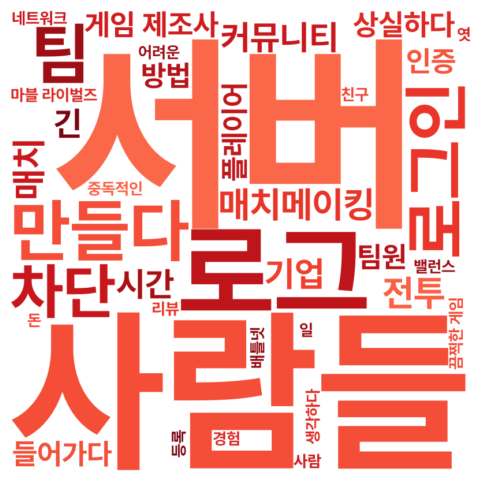

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

reds  = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### 부정 분석

- 기술 인프라
    - 서버, 네트워크, 로그인, 인증, 들어가다, 시간, 긴
        - 접속 장애, 서버 불안정, 로그인·인증 과정에서의 지연 및 오류 문제
        - 스팀으로 넘어오면서 블리자드와 연동 문제가 상당히 오랜 기간 있었는데 그것에 관한 불만으로 보임
        - 게임 로딩 및 매칭 대기 시간이 길다는 불만일 수도 있음
    - 로그
        - 시스템 오류 로그, 강제 종료, 버그 신고 관련 언급


- 매칭 및 게임 플레이 환경
    - 매치, 매치메이킹, 팀, 팀원, 밸런스, 전투, 사람들, 커뮤니티
        - 매칭 알고리즘의 공정성 부족, 실력 불균형, 팀원 간 협력 부족
        - 유저 간 갈등, 비매너 플레이, 커뮤니티 환경 악화.
        - MMR 기준 불명확, 신규/복귀 유저 보호 장치 미흡
        - 제재·버그 처리의 불투명성
        - 유저 커뮤니티에서의 불만이 누적되며 이미지 악화
        - 비매너 유저 제재 부족

- 운영 및 정책
    - 기업, 게임 제조사, 차단, 상실하다
        - 운영사·개발사에 대한 불신, 계정 제재(차단) 논란, 계정/아이템 상실 경험

- 돈, 중독적인
    - 과금 구조에 대한 부정적 인식

## 2. 플레이타임으로 나누는 만족도 비교

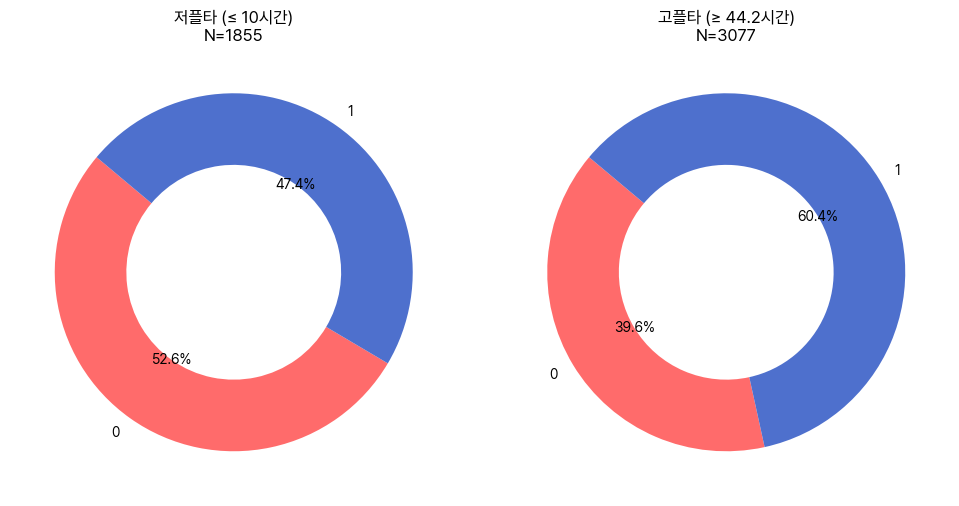

In [128]:
# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

#중립 제외
df_filtered = steam_df[steam_df['label'].isin([0, 1])].copy()

# 플레이타임 기준값 (중위수)
median_playtime = df_filtered['play_time'].median()

LOW_H = 10.0
HIGH_H = median_playtime

# 두 집단만 추출
lo = df_filtered[df_filtered['play_time'] <= LOW_H].copy()
hi = df_filtered[df_filtered['play_time'] >= HIGH_H].copy()

# 집단 크기
n_lo, n_hi = len(lo), len(hi)

# 그룹별 감성 비율 계산
def ratio_series(s):
    cnt = s.value_counts()
    pos = cnt.get(1, 0)
    neg = cnt.get(0, 0)
    total = pos + neg
    if total == 0:
        return None
    return (neg/total, pos/total)  # (부정, 긍정)

ratio_lo = ratio_series(lo['label'])
ratio_hi = ratio_series(hi['label'])

# 시각화
colors = ['#FF6B6B', "#4E70CD"]  # 부정=빨강, 긍정=청록
labels = {0: '부정', 1: '긍정'}

def plot_donut(ax, ratios, title):
    ax.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=140,
           colors=colors, wedgeprops=dict(width=0.4))
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(10,5))

if ratio_lo:
    plot_donut(axes[0], ratio_lo, f"저플타 (≤ {LOW_H:.0f}시간)\nN={n_lo}")
else:
    axes[0].text(0.5, 0.5, "데이터 없음", ha='center', va='center'); axes[0].axis('off')

if ratio_hi:
    plot_donut(axes[1], ratio_hi, f"고플타 (≥ {HIGH_H:.1f}시간)\nN={n_hi}")
else:
    axes[1].text(0.5, 0.5, "데이터 없음", ha='center', va='center'); axes[1].axis('off')

plt.tight_layout()
plt.show()

### 분석

- 10시간 이하 플레이 그룹을 '저플타'로 설정한 이유
    - 다수의 멀티플레이 게임에서 10시간은 튜토리얼 및 초기 매칭을 거쳐 기본 플레이 루프를 충분히 체험할 수 있는 시점이다.
    <br>이 시점에서 유저의 첫인상이 형성되며 잔존 여부를 가늠할 수 있다고 판단하여 10시간으로 설정하였다. 

- 저플타(10시간 이하 플레이) 그룹 : 부정 비율(52.6%)이 긍정보다 높음
    - 짧게 체험해본 유저 절반 이상이 만족하지 못하고 떠날 가능성이 높음
    - 원인 가능성
        - 초반 튜토리얼·가이드 부족
        - 매칭 품질 저하(레벨 불문 매칭, 초반부터 숙련자와 격돌)
        - 첫 플레이 보상 체감 부족

- 고플타 유저 (≥44.2시간) : 긍정 비율이 60%로 높아짐
    - 장기 플레이한 유저는 대체로 게임에 호의적
    - 하지만 40% 가까운 부정 비율 존재 → 핵심 유저층 불만 요인도 여전히 큼
    - 경쟁전 메타 불만, 밸런스 문제, 콘텐츠 반복성 등

>> 저플타 구간 부정률이 높으므로 첫 10시간 내 유저 경험을 개선해야 함
<br> ex. 좀 더 상세한 튜토리얼, 초보용 맵 가이드 등
<br> 고플타 구간으로 갈수록 긍정률이 높아지지만 부정 40%에 유저 유지를 위한 피드백이 종합되어 있을 수 있음
<br> 부정>긍정인 시간대의 그룹을 고플타 그룹으로 끌어올릴 방법 고안 필요

### 부정>긍정인 시간대 알아보기

In [ ]:
#중립 제외
df_filtered = steam_df[steam_df['label'].isin([0, 1])].copy()

# 구간 설정 (필요에 따라 변경 가능)
bins = [0,5,10,20,30,40,50,100,200,1e9]
labels = ['≤5h','5~10h','10~20h','20~30h','30~40h','40~50h','50~100h','100~200h','200h+']
df_filtered['time_band'] = pd.cut(df_filtered['play_time'], bins=bins, labels=labels, right=True)

# 구간별 긍·부정 비율 계산
summary = (
    df_filtered.groupby('time_band')['label']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .rename(columns={0:'neg',1:'pos'})
)

# 부정 > 긍정인 구간만 필터
target_bands = summary[summary['neg'] > summary['pos']].sort_values('neg', ascending=False)
display(target_bands)

C:\Users\user\AppData\Local\Temp\ipykernel_3056\4193214492.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby('time_band')['label']


label,neg,pos
time_band,,
≤5h,0.54972,0.45028


1. 5시간 이하 플레이 구간이 나왔다는 것은 게임을 충분히 체험하지 못한 상태에서 첫인상이 안 좋았던 유저들이 많다는 것을 시사한다.
2. es. 튜토리얼 완성도, 첫 매칭 품질, 초기 보상 체계 등이 평가에 큰 영향을 줄 수 있다.
>> 타겟층 중 하나를 이 그룹으로 잡아도 될듯
<br>1. 튜토리얼 개선 : HUD, 툴팁, 퀘스트 UI 등 이해도를 높여 혼란 감소
<br>2. 맞춤 매칭을 하면 좋겠지만 부계정 유저를 거를 방법이 없으니 가이드라인 제공
<br>3. 보상 설계: 5시간 이내 달성 가능한 명확한 보상 목표 제시

## 3. 추천 여부와 label의 상관관계

- 일치(agree)
<br>label == 1 & prefer == 1 → 긍정 감성 + 추천
<br>label == 0 & prefer == 0 → 부정 감성 + 비추천

- 불일치(disagree):
<br>label == 1 & prefer == 0 → 긍정 감성 + 비추천
<br>label == 0 & prefer == 1 → 부정 감성 + 추천

전체 일치율: 70.75%

케이스별 건수:


,비추천,추천
부정 감성,2102,583
긍정 감성,1217,2252



케이스별 비율(%):


,비추천,추천
부정 감성,78.286778,21.713222
긍정 감성,35.082156,64.917844


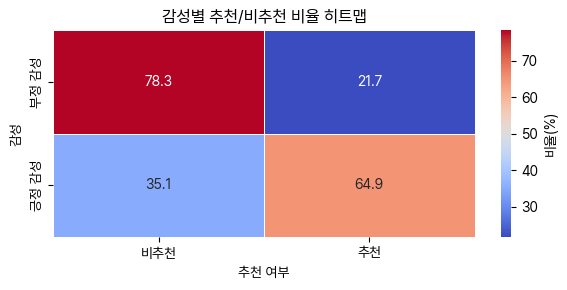

In [141]:
import seaborn as sns

# 중립 제외
df_filtered = steam_df[steam_df['label'].isin([0, 1])].copy()

# 일치 여부 계산
df_filtered['agree'] = (
    ((df_filtered['label'] == 1) & (df_filtered['prefer'] == 1)) |
    ((df_filtered['label'] == 0) & (df_filtered['prefer'] == 0)))

# 전체 일치율
overall_agree_rate = df_filtered['agree'].mean() * 100
print(f"전체 일치율: {overall_agree_rate:.2f}%")

# 상세 케이스별 비율
case_counts = df_filtered.groupby(['label', 'prefer']).size().unstack(fill_value=0)
case_counts.columns = ['비추천', '추천']
case_counts.index = ['부정 감성', '긍정 감성']

print("\n케이스별 건수:")
display(case_counts)

case_ratio = case_counts.div(case_counts.sum(axis=1), axis=0) * 100
print("\n케이스별 비율(%):")
display(case_ratio)

# 시각화 

# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# ===== 히트맵 데이터 준비 =====
heatmap_data = case_ratio.copy().astype(float)  # 비율 데이터
heatmap_data = heatmap_data[['비추천', '추천']]   # 열 순서 고정

# ===== 히트맵 =====
plt.figure(figsize=(6, 3))
sns.heatmap(
    heatmap_data,
    annot=True,           # 각 칸에 숫자 표시
    fmt=".1f",             # 소수점 1자리
    cmap="coolwarm",         # 색상맵 (빨강=낮음, 초록=높음)
    cbar_kws={'label': '비율(%)'},
    linewidths=0.5,
    linecolor='white'
)

plt.title("감성별 추천/비추천 비율 히트맵")
plt.ylabel("감성")
plt.xlabel("추천 여부")
plt.tight_layout()
plt.show()

### 분석

1. 부정 감성
- 모델이 부정으로 분류한 리뷰의 약 78%는 실제로도 비추천한다.
<br>나머지 21.7%는 부정적으로 평가했음에도 추천 버튼을 누른 경우 → 게임 전반은 좋지만 특정 불만을 서술한 케이스
<br>커뮤니티 밈/반어적 표현으로 감성 분석이 부정으로 분류했을 가능성이 있거나 장기 유저의 애정 섞인 불만일 수 있음

2. 긍정 감성
- 모델이 긍정으로 분류한 리뷰의 약 65%는 실제로도 추천한다.
<br>하지만 35.1%는 긍정적으로 평가했음에도 불구하고 비추천 → 특정 시스템이나 패치로 인한 강한 불만이 추천 여부에 직접 반영
<br>재미는 있지만 추천할 정도로 가성비/밸런스가 만족스럽지 않을 수 있음

>> 긍정 감성 + 비추천(35.1%)
<br>만족감은 있지만 구매 추천을 꺼리는 주요 불만 요인 추출 필요

>> 부정 감성 + 추천(21.7%)
<br>부정적인 피드백 중에도 ‘애정 섞인 비판’이 존재

### 불일치인 두 유형을 행동 지표로 비교

1. 불일치 그룹 분류
    - 긍정 감성 + 비추천 (label==1 & prefer==0)
    - 부정 감성 + 추천 (label==0 & prefer==1)

2. 지표 계산
    - 평균 플레이타임: play_time 평균
    - 최근 플레이 게임 패턴: recently_game1~3 빈도 상위 5개
    - 리뷰 길이
    - 작성 시점: 작성일 분포 (평균 날짜, 패치 직후 여부)

In [150]:
# ===== 1) 중립 제외 & 불일치 분류 =====
df_filtered = steam_df[steam_df['label'].isin([0, 1])].copy()

def case_type(row):
    if row['label'] == 1 and row['prefer'] == 0:
        return "긍정+비추천"
    elif row['label'] == 0 and row['prefer'] == 1:
        return "부정+추천"
    else:
        return None

df_filtered['case'] = df_filtered.apply(case_type, axis=1)
df_mismatch = df_filtered[df_filtered['case'].notna()].copy()

# ===== 2) 토큰 수 계산 =====
df_mismatch['token_count'] = df_mismatch['text'].apply(
    lambda x: len(re.findall(r'\w+', str(x)))
)

# ===== 3) 최근 플레이 게임 합치기 =====
def top_recent_games(subdf, topn=5):
    games = []
    for col in ['recently_game1', 'recently_game2', 'recently_game3']:
        games.extend(subdf[col].dropna().tolist())
    cnt = Counter(games)
    return cnt.most_common(topn)

# ===== 4) 작성일 변환 =====
df_mismatch['작성일'] = pd.to_datetime(df_mismatch['작성일'], errors='coerce')

# ===== 5) 그룹별 분석 =====
summary = []
for case, subdf in df_mismatch.groupby('case'):
    avg_playtime = subdf['play_time'].mean()
    avg_tokens = subdf['token_count'].mean()
    avg_date = subdf['작성일'].mean()
    top_games = top_recent_games(subdf, topn=5)
    summary.append({
        '케이스': case,
        'N(건)': len(subdf),
        '평균 플레이타임(h)': round(avg_playtime, 2),
        '평균 리뷰 길이(토큰)': round(avg_tokens, 1),
        '평균 작성일': avg_date.strftime('%Y-%m-%d') if pd.notna(avg_date) else None,
        '최근 플레이 TOP5': top_games
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

,케이스,N(건),평균 플레이타임(h),평균 리뷰 길이(토큰),평균 작성일,최근 플레이 TOP5
0,긍정+비추천,1217,107.15,26.5,2025-06-14,"[(비공개, 2124), (Overwatch® 2, 165), (Counter-St..."
1,부정+추천,583,163.99,15.7,2025-06-17,"[(비공개, 1014), (Overwatch® 2, 105), (Counter-St..."


### 해석

1. 긍정+비추천(N = 1217)
    - 평균 플레이타임 : 107.15시간
        - 100시간 이상 플레이 한 유저가 많음 → 게임을 깊게 한 핵심층
        - 충분히 즐겼지만 추천은 하지 않음
    - 평균 리뷰 길이 : 26.5토큰
        - 글이 비교적 긴 편 → 이유와 불만을 상세히 적는 경향이 있음(아무래도 오래 했으니까)
    - 평균 작성일 : 6월 14일

    - 최근 플레이 TOP5 : Overwatch® 2, Counter-Strike 등 경쟁성 강한 FPS 다수
        - 경쟁 환경이나 메타 불만 가능성이 큼
        
>> 게임 시스템·메타·밸런스·과금 등 구조적인 불만을 개선하면 긍정 전환 가능성이 높음.

2. 부정+추천(N = 583)
    - 평균 플레이타임: 163.99h
        - 긍정+비추천보다도 더 오래 플레이 → 진성 하드코어 유저
        - 감성 모델은 부정으로 분류했지만 실제 행동은 호의적
    - 평균 리뷰 길이: 15.7 토큰
        - 리뷰가 짧음 → 간결하게 핵심만 쓰거나, 짧은 불만·밈 사용 가능
    - 평균 작성일: 6월 17일
        - 시즌 시작일에 맞춰 작성이 집중됨 → 새로운 시즌 콘텐츠 경험 후 바로 반응
    - 최근 플레이 TOP5
        - 긍정+비추천 그룹과 같이 Overwatch® 2, Counter-Strike 등 FPS 중심

>> 글에 불만 표현이 많아 감성 모델이 부정으로 분류했지만, 전반적으로는 게임을 추천하는 충성 유저층으로 보임.
<br>커뮤니티 유머·반어 표현, 메타 비판, 운영 불만 등을 쓰면서도 “게임 자체는 좋다”는 태도.